In [1]:
import os
import numpy as np
import cv2
import glob
import matplotlib
import matplotlib.pyplot as plt
import pickle
%matplotlib inline


In [2]:
corners_found_dir='output_images/couners_found/'

nx = 9
ny = 6

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    
    # If found, add object points, image points
    if ret == True:
        
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        image_name = os.path.split(fname)[1]
        cv2.drawChessboardCorners(img, (nx ,ny), corners, ret)
        write_name = corners_found_dir + image_name
        cv2.imwrite(write_name, img)
        print("Success to find corners:", write_name)

cv2.destroyAllWindows()

Success to find corners: output_images/couners_found/calibration10.jpg
Success to find corners: output_images/couners_found/calibration11.jpg
Success to find corners: output_images/couners_found/calibration12.jpg
Success to find corners: output_images/couners_found/calibration13.jpg
Success to find corners: output_images/couners_found/calibration14.jpg
Success to find corners: output_images/couners_found/calibration15.jpg
Success to find corners: output_images/couners_found/calibration16.jpg
Success to find corners: output_images/couners_found/calibration17.jpg
Success to find corners: output_images/couners_found/calibration18.jpg
Success to find corners: output_images/couners_found/calibration19.jpg
Success to find corners: output_images/couners_found/calibration2.jpg
Success to find corners: output_images/couners_found/calibration20.jpg
Success to find corners: output_images/couners_found/calibration3.jpg
Success to find corners: output_images/couners_found/calibration6.jpg
Success t

In [3]:
# Save camera distortion
img = cv2.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "camera_dist_pickle.p", "wb" ) )

In [4]:
# Check undistorted images
with open('camera_dist_pickle.p', mode='rb') as f:
    dist_pickle = pickle.load(f)
    mtx = dist_pickle["mtx"]
    dist = dist_pickle["dist"]

undistorted_dir='output_images/undistorted/'

images = glob.glob('camera_cal/calibration*.jpg')
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    image_name=os.path.split(fname)[1]
    write_name = undistorted_dir+image_name
    cv2.imwrite(write_name,dst)
    print("Save undistorted image:", write_name)
cv2.destroyAllWindows()

test_images = glob.glob('test_images/*.jpg')

for idx, fname in enumerate(test_images):
    img = cv2.imread(fname)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    image_name=os.path.split(fname)[1]
    write_name = undistorted_dir+image_name
    cv2.imwrite(write_name,dst)
    print("Save undistorted image:", write_name)
cv2.destroyAllWindows()

Save undistorted image: output_images/undistorted/calibration1.jpg
Save undistorted image: output_images/undistorted/calibration10.jpg
Save undistorted image: output_images/undistorted/calibration11.jpg
Save undistorted image: output_images/undistorted/calibration12.jpg
Save undistorted image: output_images/undistorted/calibration13.jpg
Save undistorted image: output_images/undistorted/calibration14.jpg
Save undistorted image: output_images/undistorted/calibration15.jpg
Save undistorted image: output_images/undistorted/calibration16.jpg
Save undistorted image: output_images/undistorted/calibration17.jpg
Save undistorted image: output_images/undistorted/calibration18.jpg
Save undistorted image: output_images/undistorted/calibration19.jpg
Save undistorted image: output_images/undistorted/calibration2.jpg
Save undistorted image: output_images/undistorted/calibration20.jpg
Save undistorted image: output_images/undistorted/calibration3.jpg
Save undistorted image: output_images/undistorted/c

In [5]:
def undistort(img, mtx, dist):
    undist_image = cv2.undistort(img, mtx, dist, None, mtx)
    return undist_image

def filter_color_and_gradient(img, s_thresh=(120, 255), sx_thresh=(20, 255), l_thresh=(40,255)):
    img = np.copy(img)
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold saturation
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

    # Threshold lightness
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh[0]) & (l_channel <= l_thresh[1])] = 1
    
    color_binary = np.dstack(( l_binary , sxbinary, s_binary))

    binary = np.zeros_like(sxbinary)
    binary[(l_binary == 1) & (s_binary == 1) | (sxbinary==1)] = 1
    binary = 255*np.dstack((binary,binary,binary)).astype('uint8')            

    return binary, color_binary


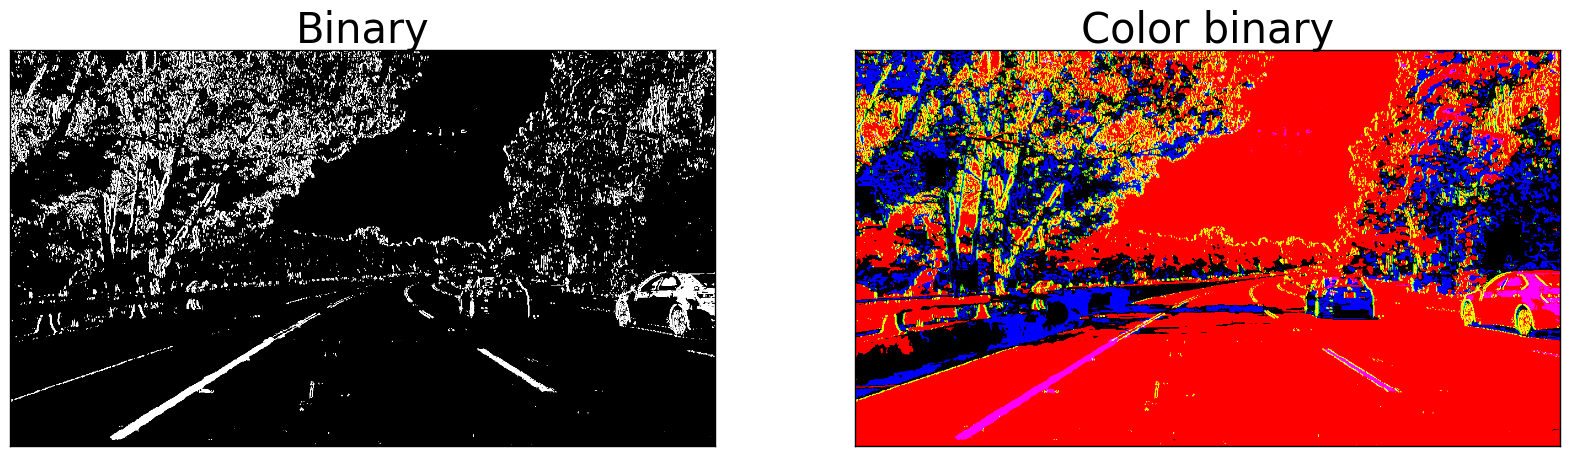

In [6]:
test_images = glob.glob('test_images/test5.jpg')

for idx, fname in enumerate(test_images):
    image = plt.imread(fname)
    undist_image = undistort(image, mtx, dist)
    binary,color = filter_color_and_gradient(undist_image)

    # Plot the result
    fig = plt.figure(figsize=(20, 6))
    subplot = fig.add_subplot(1,2,1)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.set_title('Binary', fontsize=30)
    subplot.imshow(binary)

    subplot2 = fig.add_subplot(1,2,2)
    subplot2.set_xticks([])
    subplot2.set_yticks([])
    subplot2.set_title('Color binary', fontsize=30)
    subplot2.imshow(color)
    plt.show()


In [7]:
def warp(img,tobird=True):
    corners = np.float32([[190,720],[589,457],[698,457],[1145,720]])
    new_top_left=np.array([corners[0,0],0])
    new_top_right=np.array([corners[3,0],0])
    offset=[150,0]
    
    img_size = (img.shape[1], img.shape[0])
    src = np.float32([corners[0],corners[1],corners[2],corners[3]])
    dst = np.float32([corners[0]+offset,new_top_left+offset,new_top_right-offset ,corners[3]-offset])    
    if tobird:
        M = cv2.getPerspectiveTransform(src, dst)
    else:
        M = cv2.getPerspectiveTransform(dst,src)
    warped = cv2.warpPerspective(img, M, img_size , flags=cv2.INTER_LINEAR)    
    return warped, M

def region_of_interest(img):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """    
    shape = img.shape
    vertices = np.array([[(0,0),(shape[1],0),(shape[1],0),(6*shape[1]/7,shape[0]),
                      (shape[1]/7,shape[0]), (0,0)]],dtype=np.int32)

    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


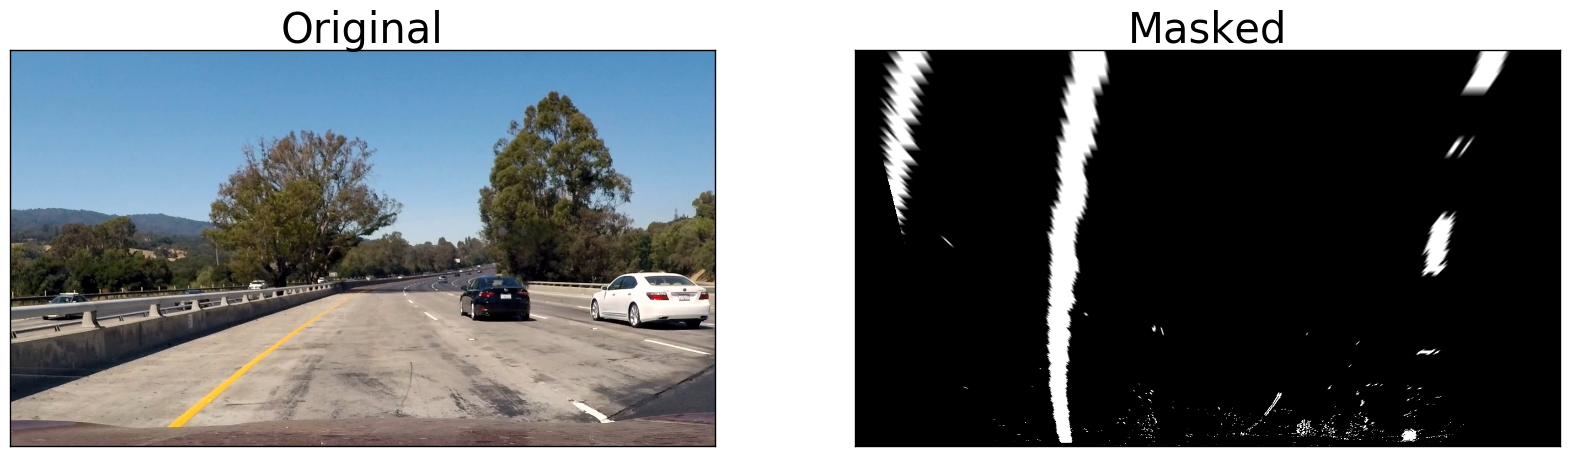

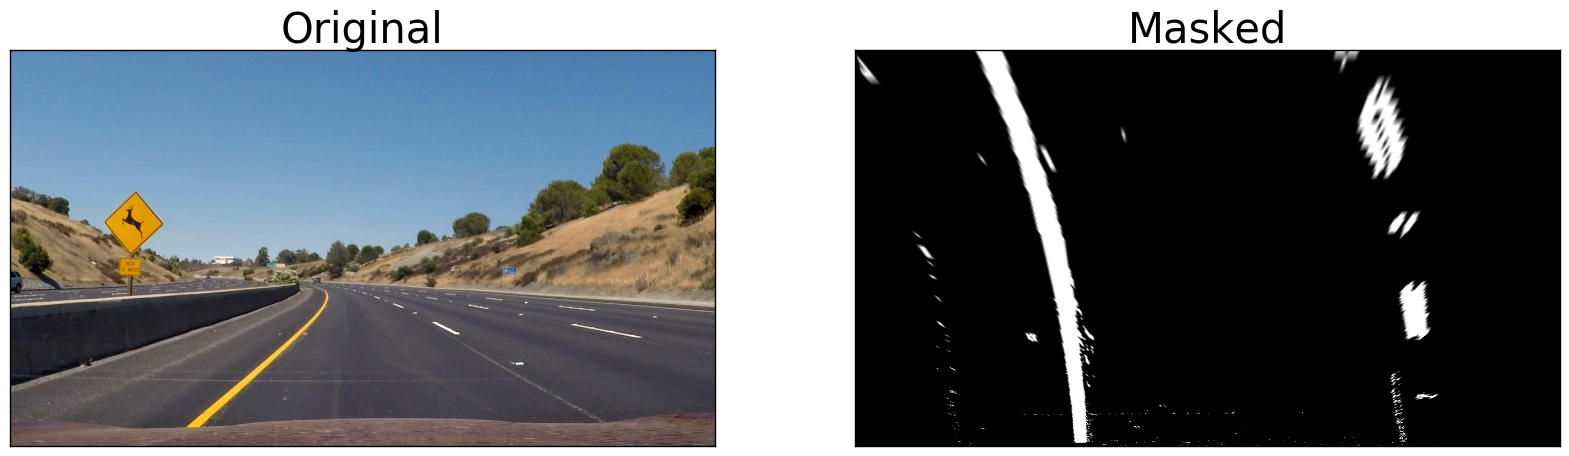

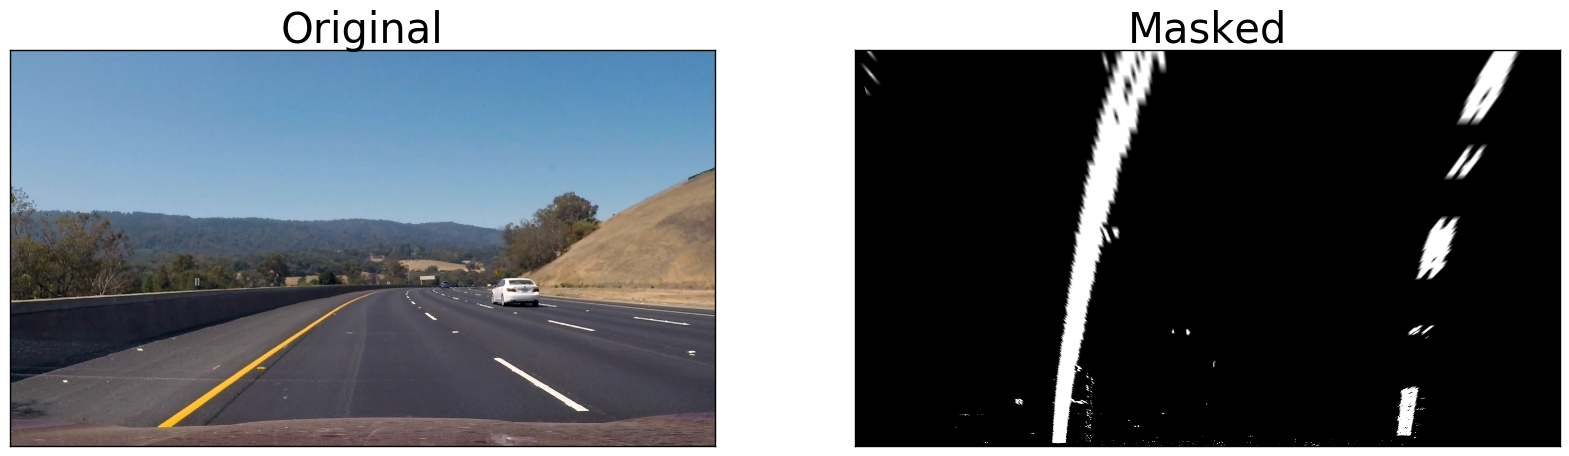

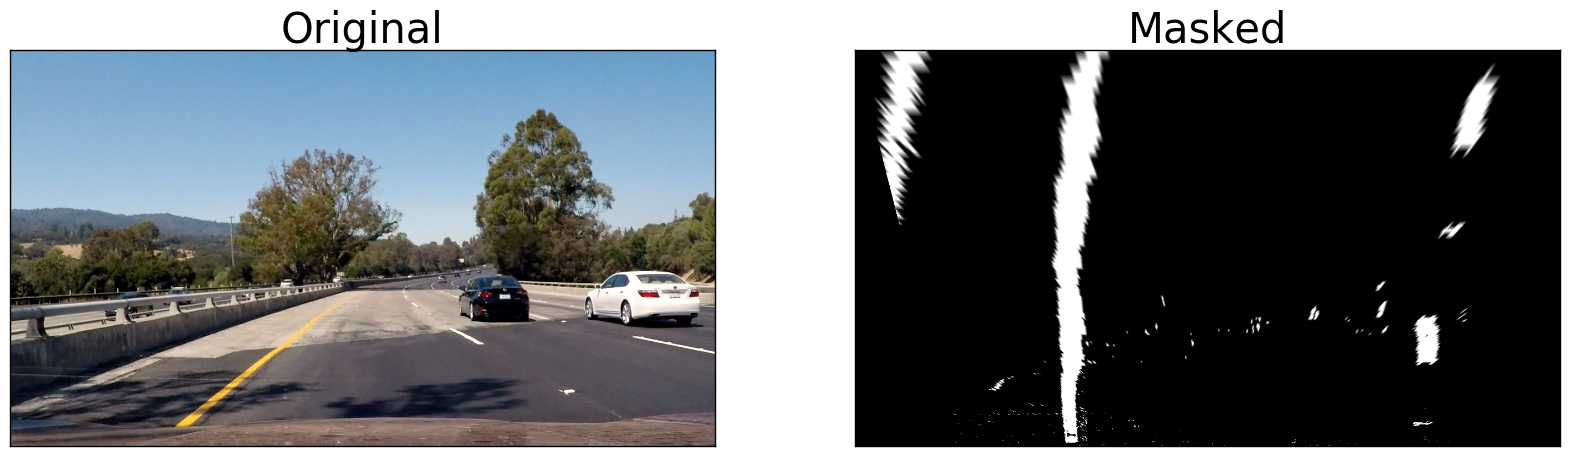

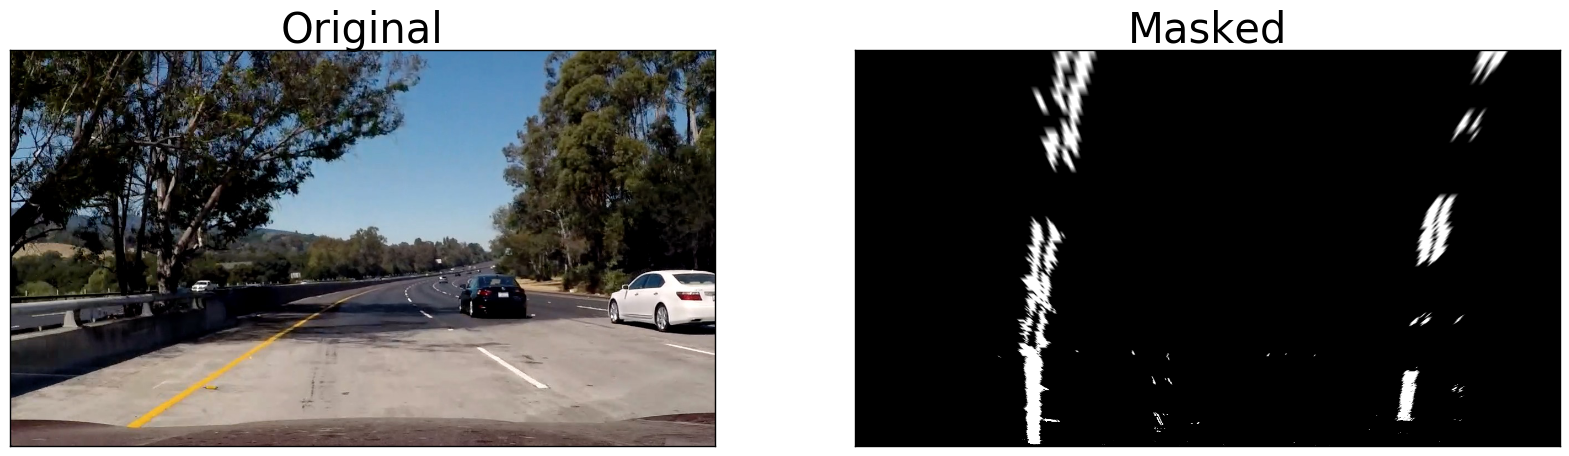

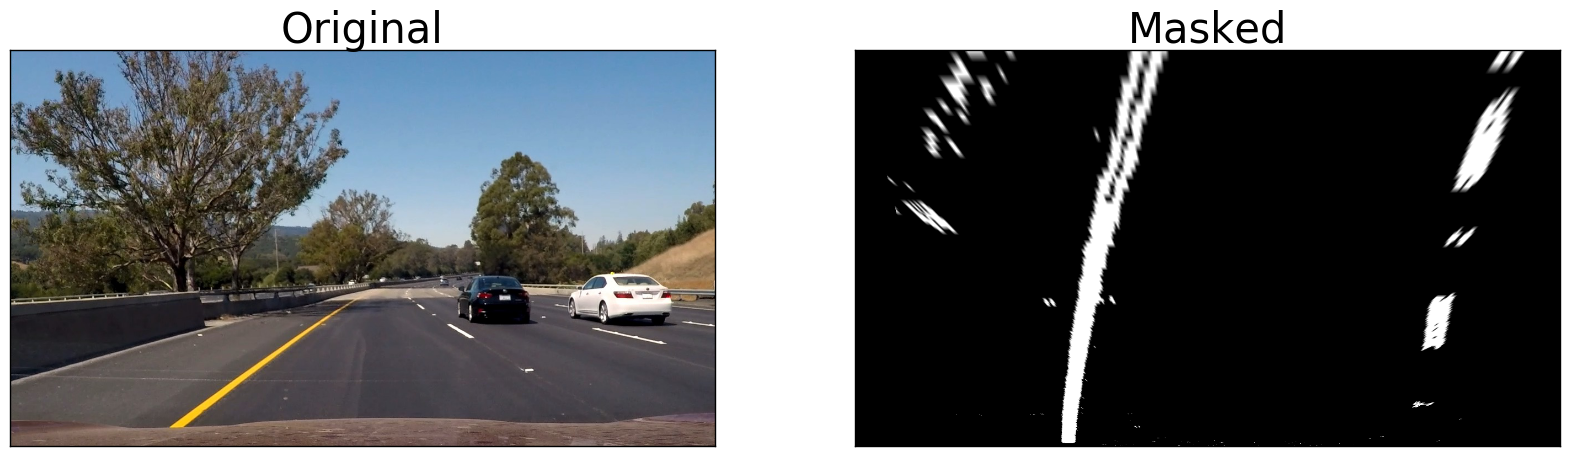

In [8]:
test_images = glob.glob('test_images/test*.jpg')

for idx, fname in enumerate(test_images):
    image = plt.imread(fname)
    undist_image = undistort(image, mtx, dist)
    binary,_ = filter_color_and_gradient(undist_image)
    warped,_ = warp(binary)
    masked_image = region_of_interest(warped)

    # Plot the result
    fig = plt.figure(figsize=(20, 6))
    subplot = fig.add_subplot(1,2,1)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.set_title('Original', fontsize=30)
    subplot.imshow(image)

    subplot2 = fig.add_subplot(1,2,2)
    subplot2.set_xticks([])
    subplot2.set_yticks([])
    subplot2.set_title('Masked', fontsize=30)
    subplot2.imshow(masked_image)
    plt.show()


In [9]:
def get_sliding_window(img,center_point,width, thresh=10000):
    """
    input: img,center_point,width
        img: binary 3 channel image
        center_point: center of window
        width: width of window
    
    output: masked,center_point
        masked : a masked image of the same size. mask is a window centered at center_point
        center : the mean ofall pixels found within the window
    """
    
    ny,nx,_ = img.shape
    mask  = np.zeros_like(img)
    if (center_point <= width/2): center_point = width/2
    if (center_point >= nx-width/2): center_point = nx-width/2
    
    left  = center_point - width/2
    right = center_point + width/2
    
    vertices = np.array([[(left,0),(left,ny), (right,ny),(right,0)]], dtype=np.int32)
    ignore_mask_color=(255,255,255)
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked = cv2.bitwise_and(mask,img)

    hist = np.sum(masked[:,:,0],axis=0)
    if max(hist > thresh):
        center = np.argmax(hist)
    else:
        center = center_point
        
    return masked,center

def get_masked_lane_image(binary,center_point,width):
    n_zones=6
    ny,nx,nc = binary.shape
    zones = binary.reshape(n_zones,-1,nx,nc)
    zones = zones[::-1] # start from the bottom slice
    window,center = get_sliding_window(zones[0],center_point,width)
   
    for zone in zones[1:]:
        next_window,center = get_sliding_window(zone,center,width)
        window = np.vstack((next_window,window))
    
    return window

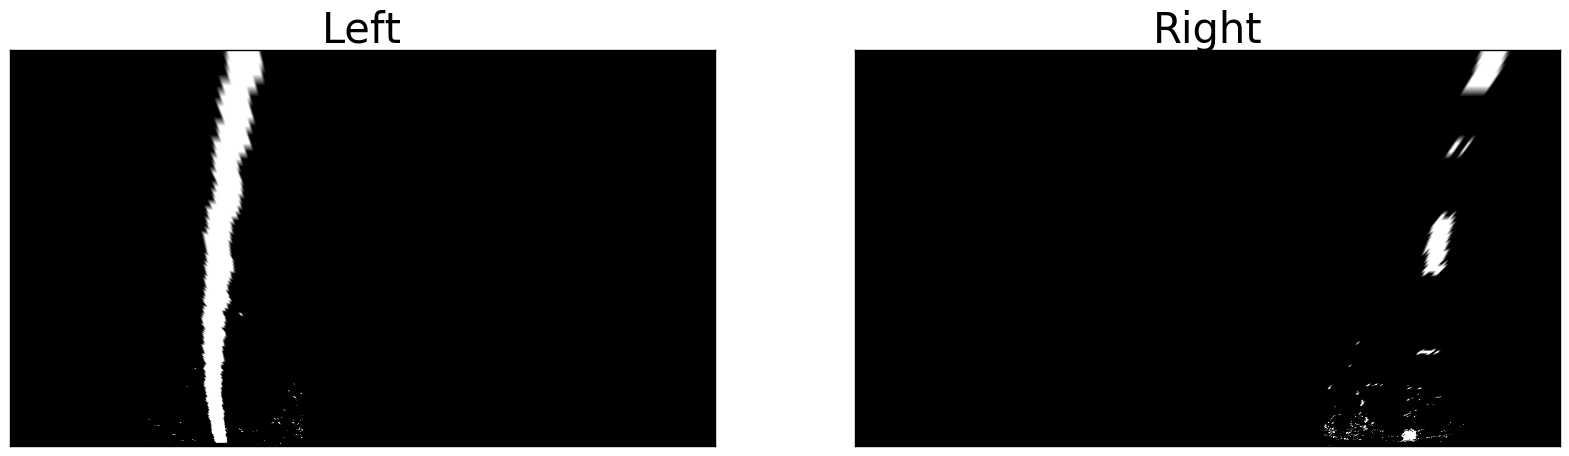

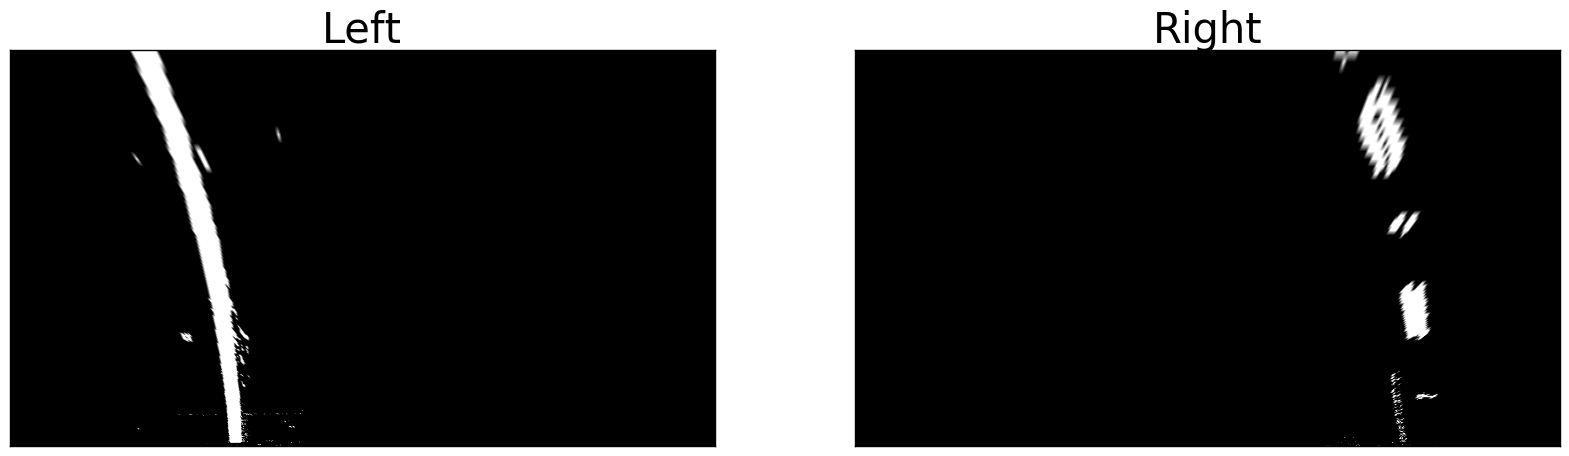

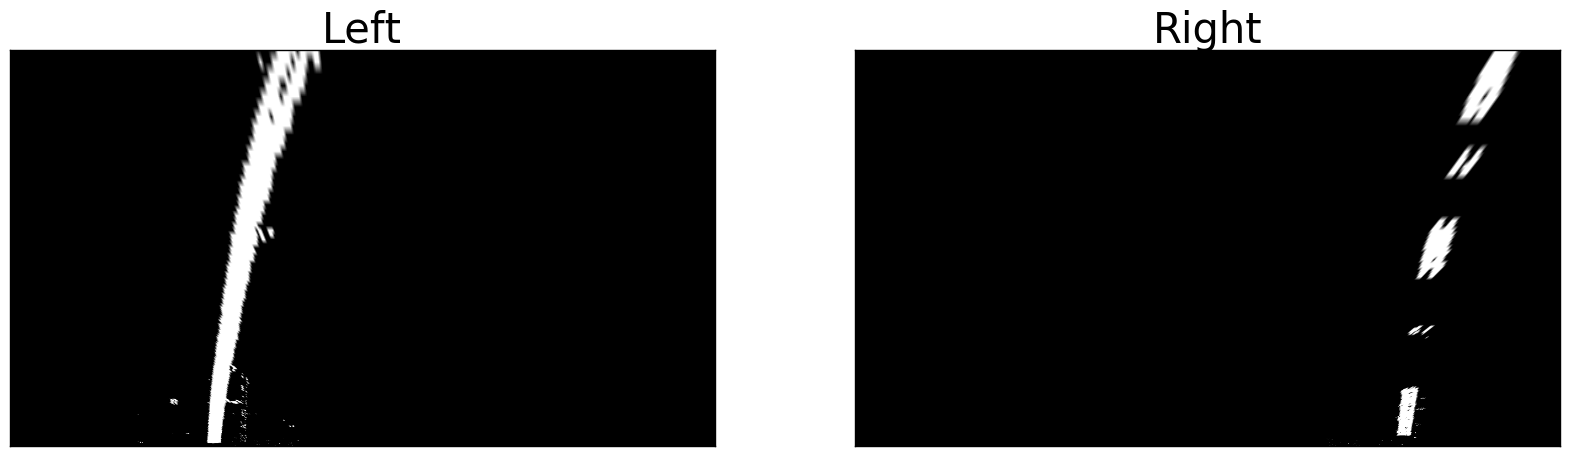

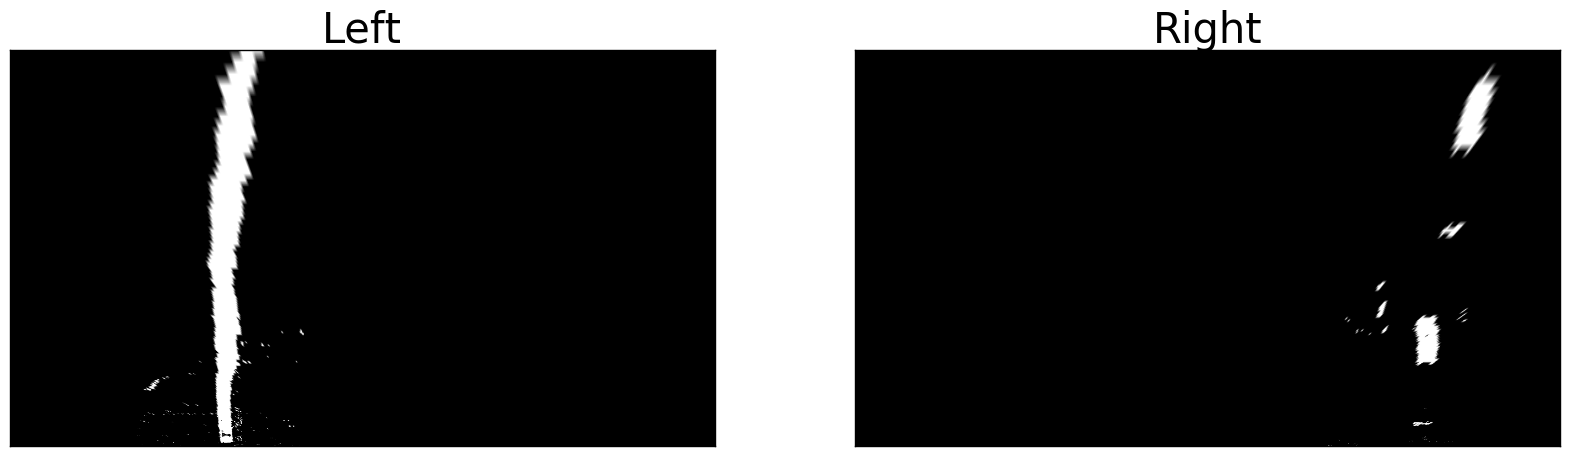

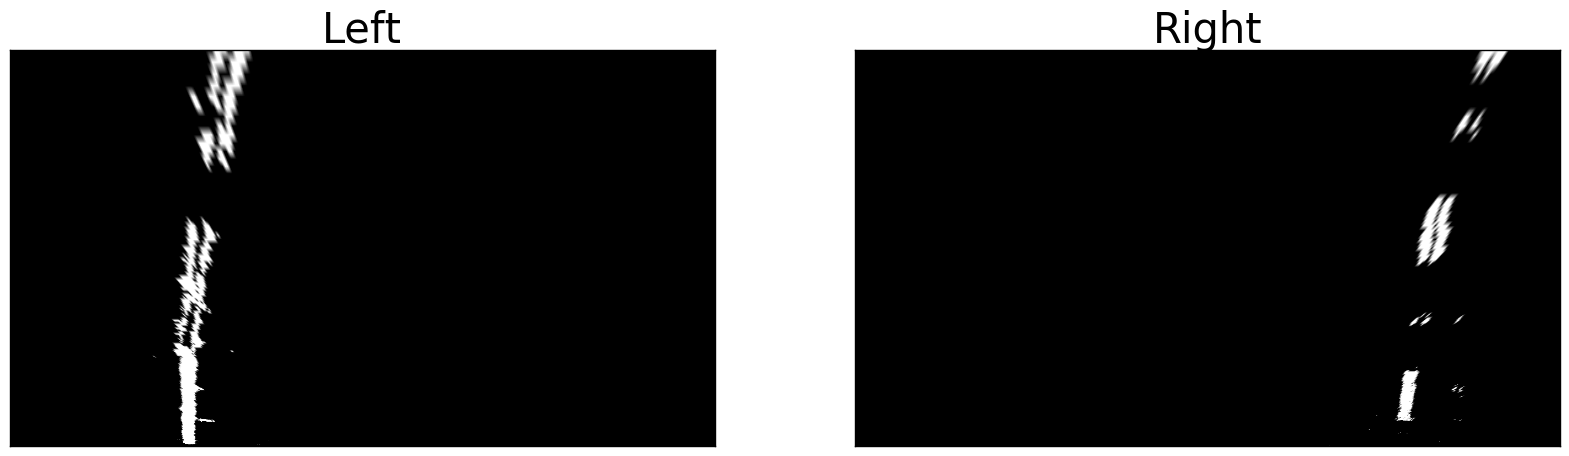

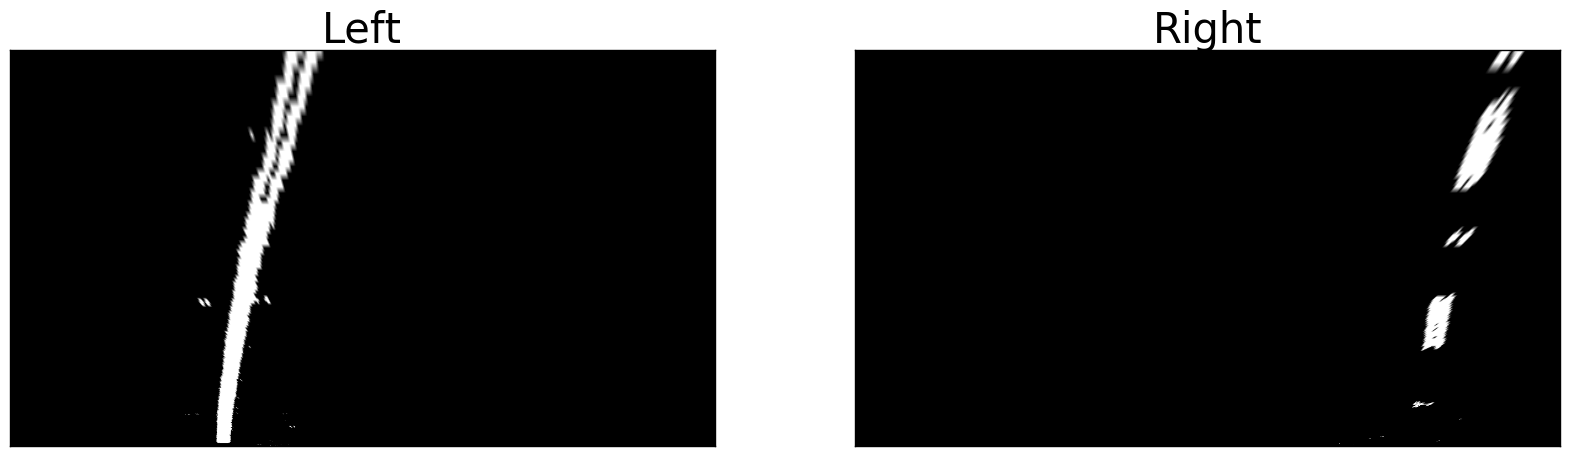

In [10]:
test_images = glob.glob('test_images/test*.jpg')

for idx, fname in enumerate(test_images):
    image = plt.imread(fname)
    undist_image = undistort(image, mtx, dist)
    binary,_ = filter_color_and_gradient(undist_image)
    warped,_ = warp(binary)
    masked_image = region_of_interest(warped)

    left_binary = get_masked_lane_image(masked_image,380,300)
    right_binary = get_masked_lane_image(masked_image,1000,300)

    lanes_line_dir='output_images/lane_lines/'

    image_name=os.path.split(fname)[1]

    plt.imsave(lanes_line_dir+'left_'+image_name, left_binary)
    plt.imsave(lanes_line_dir+'right_'+image_name, right_binary)

    # Plot the result
    fig = plt.figure(figsize=(20, 6))
    subplot = fig.add_subplot(1,2,1)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.set_title('Left', fontsize=30)
    subplot.imshow(left_binary)

    subplot2 = fig.add_subplot(1,2,2)
    subplot2.set_xticks([])
    subplot2.set_yticks([])
    subplot2.set_title('Right', fontsize=30)
    subplot2.imshow(right_binary)
    plt.show()


In [11]:
from collections import deque

# Define a class to receive the characteristics of each line detection
class Line:
    def __init__(self,n=5):
        # length of queue to store data
        self.n = n
        #number of fits in buffer
        self.n_buffered = 0
        # was the line detected in the last iteration?
        self.detected = False  
        # average x values of the fitted line over the last n iterations
        self.best_xvals = None
        # polynomial coefficients averaged over the last n iterations
        self.best_coeffs = None  
        # xvals of the most recent fit
        self.current_fit_xvals = []  
        #polynomial coefficients for the most recent fit
        self.current_fit_coeffs = []          
        # x values of the last n fits of the line
        self.recent_fit_xvals = deque([],maxlen=n)
        # fit coeffs of the last n fits
        self.recent_fit_coeffs = deque([],maxlen=n)        
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        #y values for line fit
        self.fit_yvals = np.linspace(0, 720, num=100) 
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #distance in pixels of vehicle center from the line
        self.line_pix_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float')        
                                            
    def get_fit_lines(self):
            return self.current_fit_xvals, self.fit_yvals

    def get_detect_lines(self):
            return self.allx, self.ally

    def get_last_x_pos(self):
        if self.detected==True:
            return self.line_pix_pos
        else:
            return None

    def get_best_fit_lines(self):
            return self.best_xvals, self.fit_yvals

    def get_driving_info(self):
            return self.radius_of_curvature, self.line_base_pos

    def sanity_checks_of_lines(self):
        flag = True
        maxdist = 2.8  # distance in meters from the lane
        if(abs(self.line_base_pos) > maxdist ):
            print('lane too far away')
            flag  = False        
        if(self.n_buffered > 0):
            relative_delta = self.diffs / self.best_coeffs
            # allow maximally this percentage of variation in the fit coefficients from frame to frame
            if not (abs(relative_delta)<np.array([0.7,0.5,0.15])).all():
                #print('fit coeffs too far off [%]',relative_delta)
                flag=False
                
        return flag
    
    def update(self,lane):

        self.ally,self.allx = (lane[:,:,0]>254).nonzero()

        # Define conversions in x and y from pixels space to meters
        ym_per_pix = 40.0/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meters per pixel in x dimension

        # Fit new polynomials to x,y in world space
        yvals = self.ally*ym_per_pix
        xvals = self.allx*xm_per_pix
        self.current_fit_coeffs = np.polyfit(yvals, xvals, 2)

        # Calculate xvals
        fit_yvals = self.fit_yvals * ym_per_pix       
        self.current_fit_xvals = (self.current_fit_coeffs[0]*fit_yvals**2 \
            + self.current_fit_coeffs[1]*fit_yvals + self.current_fit_coeffs[2]) / xm_per_pix
        
        y_eval = max(fit_yvals)

        # Calculate the new radii of curvature
        self.radius_of_curvature = ((1 + (2*self.current_fit_coeffs[0]*y_eval + self.current_fit_coeffs[1])**2)**1.5) \
                         /np.absolute(2*self.current_fit_coeffs[0])

        # Calculate the line base position
        line_base_pos = self.current_fit_coeffs[0]*y_eval**2 \
                        + self.current_fit_coeffs[1]*y_eval \
                        + self.current_fit_coeffs[2]
        self.line_pix_pos = line_base_pos / xm_per_pix
        center_pos = 680 * xm_per_pix
        self.line_base_pos = (line_base_pos - center_pos)

        # Calculate the diffrence coeffs
        if self.n_buffered > 0:
            self.diffs = self.current_fit_coeffs - self.best_coeffs
        else:
            self.diffs = np.array([0,0,0], dtype='float')                 

        if self.sanity_checks_of_lines():
            self.detected=True
            self.recent_fit_xvals.append(self.current_fit_xvals)
            self.recent_fit_coeffs.append(self.current_fit_coeffs)
            self.n_buffered = len(self.recent_fit_xvals)
            self.best_xvals = np.mean(self.recent_fit_xvals, axis=0)            
            self.best_coeffs = np.mean(self.recent_fit_coeffs, axis=0)
        else:
            self.detected=False
                    
        return self.detected,self.n_buffered
    


[Left]radius_of_curvature =  49122.626684
[Left]line position =  -1.72405180398
[Right]radius_of_curvature =  12869.5166677
[Rihgt]line position =  1.51919487577


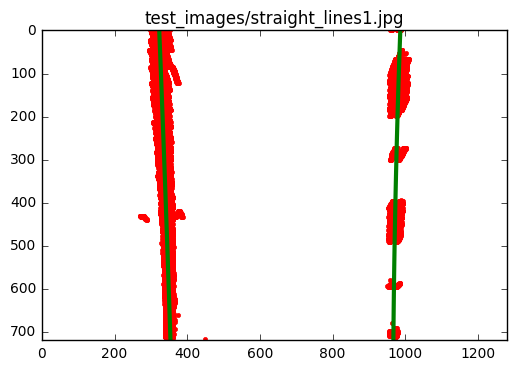

[Left]radius_of_curvature =  8102.48820947
[Left]line position =  -1.69268253407
[Right]radius_of_curvature =  46132.1713093
[Rihgt]line position =  1.51836958101


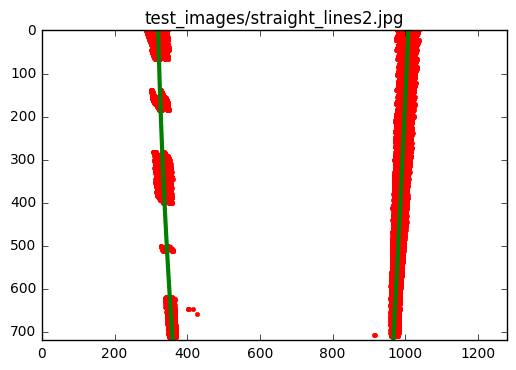

[Left]radius_of_curvature =  1693.68096313
[Left]line position =  -1.61862484824
[Right]radius_of_curvature =  9980.05354929
[Rihgt]line position =  1.40159139678


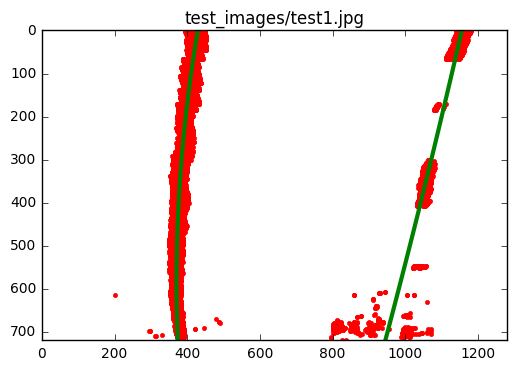

[Left]radius_of_curvature =  1047.26756337
[Left]line position =  -1.43622784362
[Right]radius_of_curvature =  927.432332857
[Rihgt]line position =  1.75514066812


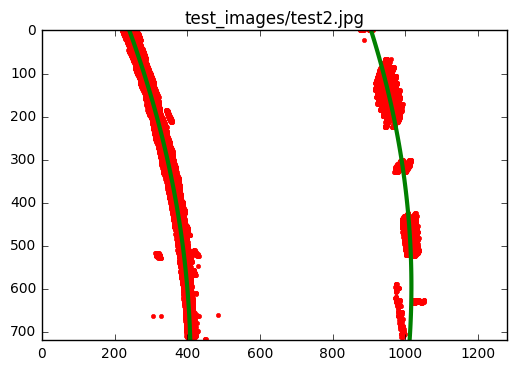

[Left]radius_of_curvature =  1787.11849075
[Left]line position =  -1.64212346617
[Right]radius_of_curvature =  1302.57589222
[Rihgt]line position =  1.65011316011


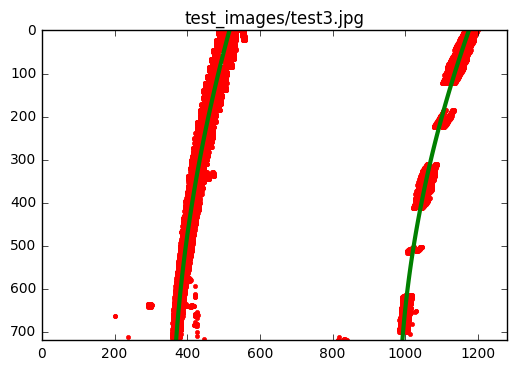

[Left]radius_of_curvature =  1877.90234152
[Left]line position =  -1.51157462097
[Right]radius_of_curvature =  720.752043229
[Rihgt]line position =  1.85823860013


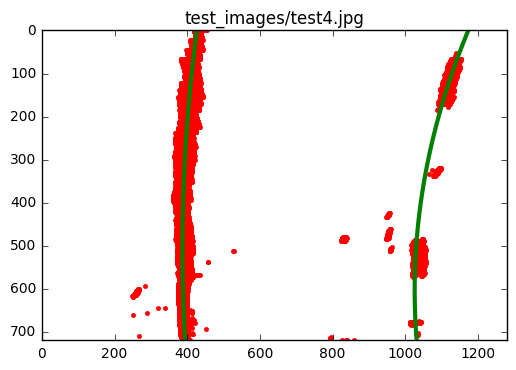

[Left]radius_of_curvature =  1400.36209441
[Left]line position =  -1.88096490282
[Right]radius_of_curvature =  1117.82508571
[Rihgt]line position =  1.66552213576


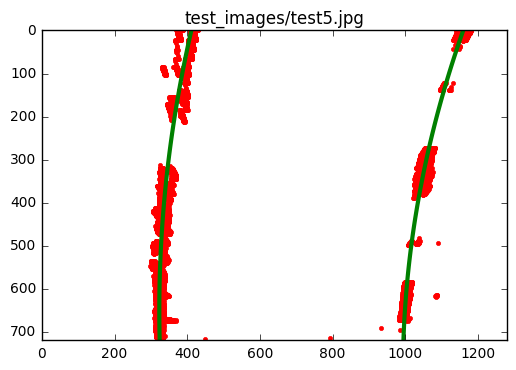

[Left]radius_of_curvature =  2060.01220768
[Left]line position =  -1.57614297409
[Right]radius_of_curvature =  2375.22092801
[Rihgt]line position =  1.75706738506


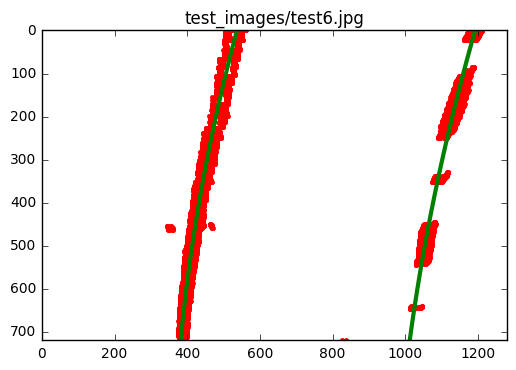

In [12]:
test_images = glob.glob('test_images/*.jpg')

for idx, fname in enumerate(test_images):
    test_left=Line()
    test_right=Line()
    img = plt.imread(fname)

    undist = undistort(img, mtx, dist)
    binary,_  = filter_color_and_gradient(undist)
    warped,_  = warp(binary)
    warped_binary = region_of_interest(warped)
    
    window_center_l = 340
    left_binary = get_masked_lane_image(warped_binary,window_center_l,width=300)
    
    window_center_r = 940
    right_binary = get_masked_lane_image(warped_binary,window_center_r,width=300)

    detected_l,n_buffered_left = test_left.update(left_binary)
    detected_r,n_buffered_right = test_right.update(right_binary)

    left_x, left_y = test_left.get_detect_lines()
    left_fitx, left_fity = test_left.get_fit_lines()
    left_roc, left_pos = test_left.get_driving_info()
    print("[Left]radius_of_curvature = ", left_roc)
    print("[Left]line position = ", left_pos)

    right_x, right_y = test_right.get_detect_lines()
    right_fitx, right_fity = test_right.get_fit_lines()
    right_roc, right_pos = test_right.get_driving_info()
    print("[Right]radius_of_curvature = ", right_roc)
    print("[Rihgt]line position = ", right_pos)

    plt.plot(right_x, right_y, '.', color='red')
    plt.plot(right_fitx, right_fity, color='green', linewidth=3)

    plt.plot(left_x, left_y, '.', color='red')
    plt.plot(left_fitx, left_fity, color='green', linewidth=3)

    plt.xlim(0, 1280)
    plt.ylim(0, 720)
    plt.title(fname)
    plt.gca().invert_yaxis()
    plt.show()


In [13]:
def find_lines_base(img):
    img_half=img[img.shape[0]/2:,:,0]
    histogram = np.sum(img_half, axis=0)
    midpoint = np.int(histogram.shape[0] / 2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    lines_base = np.array([leftx_base, rightx_base])
    return lines_base

In [14]:
def project_lane_lines(img,left_fitx,right_fitx,yvals):
    
    # Create an image to draw the lines on
    color_warp = np.zeros_like(img).astype(np.uint8)

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, yvals]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, yvals])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    unwarp,Minv = warp(img,tobird=False)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 

    # Combine the result with the original image
    undist = undistort(img, mtx, dist)    
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    return result

In [15]:
def process_image(img):
    global left
    global right
    undist = undistort(img, mtx, dist)
    binary,_  = filter_color_and_gradient(undist)
    warped,_  = warp(binary)
    warped_binary = region_of_interest(warped)
    
    left_pos = left.get_last_x_pos()
    right_pos = right.get_last_x_pos()
    if  (left_pos != None) and (right_pos != None):
        left_binary = get_masked_lane_image(warped_binary, left_pos, width=300)
        right_binary = get_masked_lane_image(warped_binary, right_pos, width=300)
    else : 
        lines_base = find_lines_base(warped_binary)
        left_binary = get_masked_lane_image(warped_binary, lines_base[0], width=300)
        right_binary = get_masked_lane_image(warped_binary, lines_base[1], width=300)
            
    detected_l,n_buffered_left = left.update(left_binary)
    detected_r,n_buffered_right = right.update(right_binary)    
    
    left_fitx, fity = left.get_best_fit_lines()
    right_fitx, fity = right.get_best_fit_lines()
    
    left_roc, left_pos_w = left.get_driving_info()
    right_roc, right_pos_w = right.get_driving_info()
 
    off_center = -round(np.mean([left_pos_w,right_pos_w]),2)
    curvature = round(np.mean([left_roc,right_roc]), 1)

    result = project_lane_lines(img,left_fitx,right_fitx,fity)
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    str1 = str('distance from center: '+str(off_center)+'m')
    cv2.putText(result,str1,(100,100), font, 2,(255,255,255),2,cv2.LINE_AA)
    str2 = str('radius of curvature: '+str(curvature)+'m')
    cv2.putText(result,str2,(100,200), font, 2,(255,255,255),2,cv2.LINE_AA)    
    
    return result

/Users/hideto.kimura/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:2: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  from ipykernel import kernelapp as app


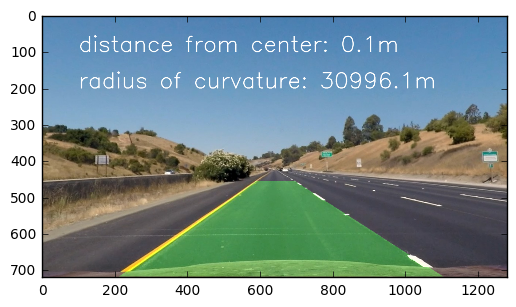

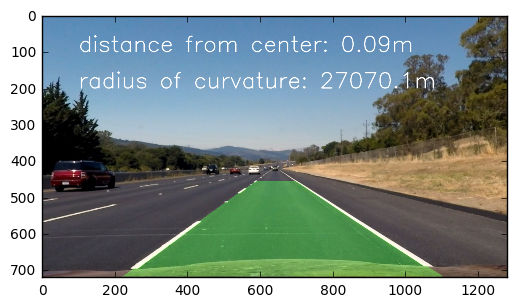

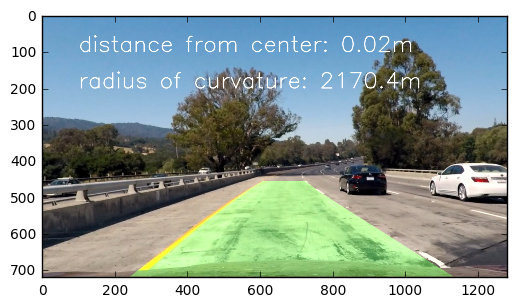

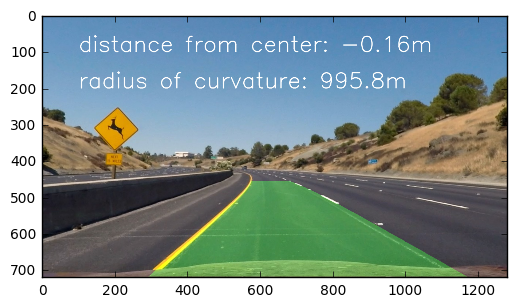

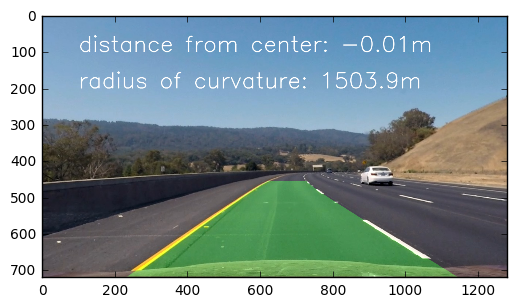

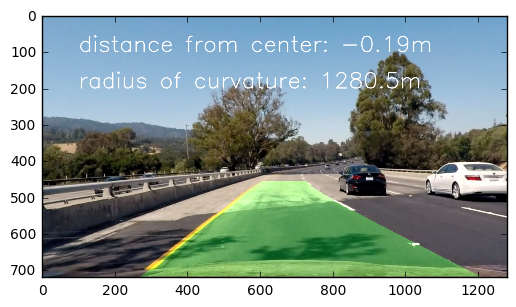

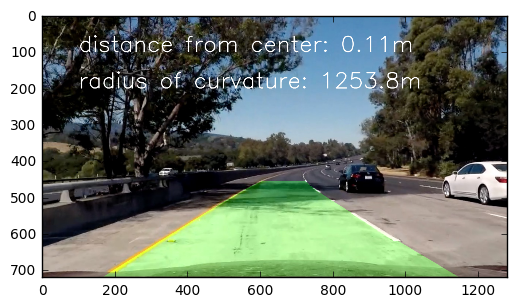

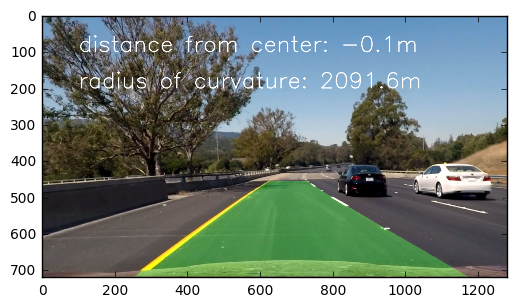

In [16]:
test_images = glob.glob('test_images/*.jpg')

for idx, fname in enumerate(test_images):
    left = Line()
    right = Line()

    new_image = plt.imread(fname)
    result = process_image(new_image)
    result = process_image(new_image)
    plt.figure()
    plt.imshow(result)
    plt.show()
    

In [17]:
import imageio
imageio.plugins.ffmpeg.download()
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip

left = Line(7)
right = Line(7)

out_dir='./'
output = out_dir+'processed_project_video.mp4'
clip = VideoFileClip("project_video.mp4")
out_clip = clip.fl_image(process_image) 
%time out_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video ./processed_project_video.mp4
[MoviePy] Writing video ./processed_project_video.mp4


100%|█████████▉| 1260/1261 [08:06<00:00,  2.91it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./processed_project_video.mp4 

CPU times: user 7min 56s, sys: 1min 42s, total: 9min 39s
Wall time: 8min 8s
